This notebook contains the final assignment of the cursera's course: `Machine Learning with Python`

**Final Assignment**
<br/> Author: Emerson Goncalves
<h1 align='center'><font size='4'> Classification with Python </font></h1> 

OBJECTIVES:
- Use loans dataset alongside with machine learningn algorights to say whether a loan will default.
- Expeted Machine learning algorithms:
    - Decision Tree
    - k-nearest Neighbour
    - Support Vector Machine
    - Logistic Regression
- Metrics to access the performance of the models:
    - Jaccard Index
    - F1-score
    - Log Loass

Loading packages

In [1]:
import itertools

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter

import matplotlib.ticker as ticker


from sklearn import preprocessing

C:\Users\emers\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load dataset

In [2]:
link = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv'

data = pd.read_csv(link)
data.head(3)

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male


Data Wrangling

In [3]:
# Converting the date columns to date type

data['effective_date'] = pd.to_datetime(data['effective_date'])
data['due_date'] = pd.to_datetime(data['due_date'])

In [4]:
 data.groupby(['loan_status']).count()

,Unnamed: 0.1,Unnamed: 0,Principal,terms,effective_date,due_date,age,education,Gender
loan_status,,,,,,,,,
COLLECTION,86,86,86,86,86,86,86,86,86
PAIDOFF,260,260,260,260,260,260,260,260,260


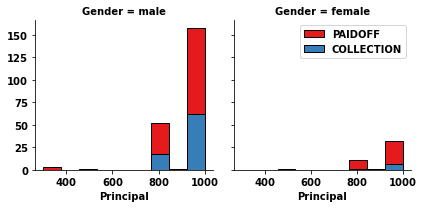

In [5]:
import seaborn as sns

bins = np.linspace(data.Principal.min(), data.Principal.max(), 10)
g = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

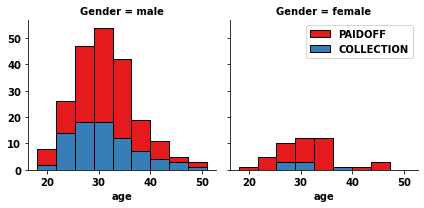

In [6]:
bins = np.linspace(data.age.min(), data.age.max(), 10)
g = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

**Pre-processing: Feature Selection/Extraction**

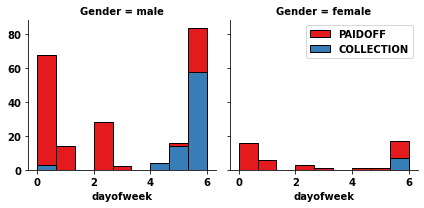

In [7]:
# Selection of what day of the week people get the loan.
data['dayofweek'] = data['effective_date'].dt.dayofweek

bins = np.linspace(data.dayofweek.min(), data.dayofweek.max(), 10)
g = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Based on the charts above, loans that are taken on the weeked, are not paid off.

In [8]:
# This creates a column to say whether the day is weekend or not.

data['weekend'] = data['dayofweek'].apply(lambda x:1 if (x>3) else 0)
data.head(5)

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


Converting categorical attributes to numerial booleans values:

Gender

In [9]:
# Checking the gender:

data.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [10]:
# GENDER:
#  Converting male to 0 and famale to 1:

data['Gender'].replace(to_replace = ['male','female'], value = [0,1], inplace = True)

Education

In [11]:
data.groupby(['education'])['loan_status'].value_counts(normalize = True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Education attribute can assume 4 labels : `Bachelor,high school or below, Master or above, college`.
In order to use this attribute, let us use hot encoding to transform these 4 labels into columns ans assign them 0 or 1 values.

In [12]:
# Getting the education attribute transformed into for 4 columns:

ed = pd.get_dummies(data['education'])

# Dropping the 'Master or Above' column:
ed.drop(['Master or Above'], axis = 1, inplace = True)

# Merging the new education collumns into the dataframa that will store the features data

feature = data[['Principal','terms','age','Gender','weekend']]
x = pd.concat([feature, ed], axis = 1)

x.head(5)

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [13]:
y = data['loan_status'].values

**Normalize Data**
<br/> Data standardization give data zero  mean and unit variance.

In [14]:
X = preprocessing.StandardScaler().fit(x).transform(x)

## Classification

Use the training set to build an accurate model. Then use the test set to report the accuracy of the model. Use the following algorithm:

- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

__ Notice:__

The pre-processing, feature selection, feature-extraction, and so on, can be changed to make a better model.
Use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.

#### 1 - K Nearest Neighbor(KNN)

<br/>CONCEPT:
<br/> KNN is a classifier algorithm that takes labels points to classify an unlabeled point based on its nearest neighbours.
<br/> `n` is the number of most near neighbours being considered in the classification.

<br/> Notice: Find the best k to build the model with the best accuracy.
<br/> warning: Do not use the loan_test.csv for finding the best k, however, you can split your train_loan.csv into train and test to find the best k.

In [15]:
# Loading related Libraries

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [16]:
#  Pre-processing spliting the data into train and  test dataset:

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state = 4)

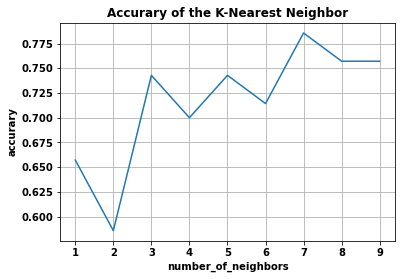

In [17]:
# TRAINNING K-Nearest Neighbor;

knn_score = []

# Loop to test different values of K
for k in range(1,10):
    # Fitting the model
    neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train,y_train)
    
    # Acuracy evaluation/ Out of sample assessment:
    score = metrics.accuracy_score(y_test,neigh.predict(x_test))
    
    # Storing the accuracy values
    knn_score.append([k,score])

    
knn_score = pd.DataFrame(knn_score,columns= ['k','score'])

# Plotting of the results:

fig, ax = plt.subplots()
ax.plot(knn_score.k, knn_score.score)

ax.set(xlabel='number_of_neighbors', ylabel='accurary',
       title='Accurary of the K-Nearest Neighbor')
ax.grid()

plt.show()

In [18]:
## FINDING THE BEST 'N' PARAMETER:
knn_score[knn_score["score"] == knn_score["score"].max()]

,k,score
6,7,0.785714


The best N parameter is, `N=7`

#### 2 - Decision Tree
CONCEPTS:
<br/>  The basic intuition behind the desicion tree is to map out the possible decision paths in the form of a tree.
<br/> The split of the data is made taking the attribute that when splited will increase the purity of the data and therefore decrease the entropy of the data. 

In [19]:
# Importing the necessary libraries:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

In [20]:
# Modeling the Decision Tree:

d_tree = []

# Fitting the model:
d_t = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4).fit(x_train,y_train)
    
# Out of sample accuracy evaluation: 
score = metrics.accuracy_score(y_test, d_t.predict(x_test))

In [21]:
# FINDING THE BEST 'Max Depth' PARAMETER
# d_tree[d_tree['accuracy'] == d_tree['accuracy'].max()]

The best max depth parameter is `max_depth = 1`

#### 3- Support Vector Machine

The SVM algorithm offers a choice of kernels functions for performing its processing:
 - Linear
 - Polynomial
 - Radial basis Function
 - Sigmoid
 
<br/>These function are used to map the data into a higher dimensional space.
<br/>Each function has its features, pros and cons. There is not easy way to knowing which function fits best the problems being modeled.

In [22]:
# Importing the necessary labrary:

from sklearn import svm

In [23]:
# FITTING THE MODEL
# The kernel function to be used in this modeling is:

clf = svm.SVC().fit(x_train,y_train)

score = metrics.accuracy_score(y_test,clf.predict(x_test))

score

0.7428571428571429

#### 4- Logistic Regression

In [24]:
# Importing the necessary libraries
from sklearn.linear_model  import LogisticRegression

In [25]:
# FITTING THE MODEL:

# C indicates the Regularization in the model, the C value indicated the inverse of the regularization strength,
# Smaller values of C set stronger regularization.

LR = LogisticRegression(C = 0.01).fit(x_train,y_train)
score = metrics.accuracy_score(y_test,LR.predict(x_test))

### Model Evaluation Using the test dataset

In [26]:
# Loading the necessary libraries:

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [27]:
# Loading the test dataset:

link = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'

tst_data = pd.read_csv(link)

tst_data.head(3)

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female


**Preparing the test dataset**

In [28]:
# Converting the date columns to date type:
tst_data['effective_date'] = pd.to_datetime(tst_data['effective_date'])
tst_data['due_date'] = pd.to_datetime(tst_data['due_date'])
#_____________//_________

# GENDER,converting male to 0 and famale to 1:

tst_data['Gender'].replace(to_replace = ['male','female'], value = [0,1], inplace = True)
#_____________//_________

# Selection of what day of the week people get the loan.
tst_data['dayofweek'] = tst_data['effective_date'].dt.dayofweek
#_____________//_________

# This creates a column to say whether the day is weekend or not.
tst_data['weekend'] = tst_data['dayofweek'].apply(lambda x:1 if (x>3) else 0)
#_____________//_________

# Getting the education attribute transformed into for 4 columns:
ed_tst = pd.get_dummies(tst_data['education'])

    # Dropping the 'Master or Above' column:
ed_tst.drop(['Master or Above'], axis = 1, inplace = True)

    # Merging the new education collumns into the dataframa that will store the features data

feature_tst = tst_data[['Principal','terms','age','Gender','weekend']]
x_tst = pd.concat([feature_tst, ed_tst], axis = 1)

In [29]:
y_tst = tst_data['loan_status'].values

Normalize the test dataset

In [30]:
X_tst = preprocessing.StandardScaler().fit(x_tst).transform(x_tst)

In [31]:
X_tst.shape

(54, 8)

In [32]:
y_tst.shape

(54,)

### Report

In [33]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

**Jaccard_score**
<br/>`Accuracy` classification score is a function that computes subset accuracy. This function is equal to the `jaccard_score function`

In [34]:
# KNN

# Best parameter found, number of neighbors  = 40

metrics.accuracy_score(y_tst, KNeighborsClassifier(n_neighbors = 7).fit(x_train,y_train).predict(X_tst))


0.6851851851851852

In [35]:
j_KNN = jaccard_score(y_tst, KNeighborsClassifier(n_neighbors = 7).fit(x_train,y_train).predict(X_tst), pos_label = 'PAIDOFF')
j_KNN

0.6666666666666666

In [36]:
# DECISION TREE

# Best parameter found, maximum depth of the tree  = 1
    
metrics.accuracy_score(y_tst, DecisionTreeClassifier(criterion = 'entropy',max_depth = 1).fit(x_train,y_train).predict(X_tst))

0.7407407407407407

In [37]:
j_DT = jaccard_score(y_tst, DecisionTreeClassifier(criterion = 'entropy',max_depth = 1).fit(x_train,y_train).predict(X_tst), pos_label = 'PAIDOFF')
j_DT

0.7407407407407407

In [38]:
#SVM

metrics.accuracy_score(y_tst,svm.SVC(kernel = 'rbf').fit(x_train,y_train).predict(X_tst))


0.7962962962962963

In [39]:
j_SVM = jaccard_score(y_tst,svm.SVC(kernel = 'rbf').fit(x_train,y_train).predict(X_tst), pos_label = 'PAIDOFF')
j_SVM

0.78

In [40]:
#LOGISTIC REGRESSION

# Best regularization parameter, C=1
metrics.accuracy_score(y_tst,LogisticRegression(C = 1, solver = 'liblinear').fit(x_train,y_train).predict(X_tst))

0.7592592592592593

In [41]:
j_LR = jaccard_score(y_tst,LogisticRegression(C = 1, solver = 'liblinear').fit(x_train,y_train).predict(X_tst), pos_label = 'PAIDOFF')
j_LR

0.75

**f1_score**

In [42]:
# KNN

# Best parameter found, number of neighbors  = 40

f_KNN = f1_score(y_tst, KNeighborsClassifier(n_neighbors = 7).fit(x_train,y_train).predict(X_tst), average='weighted')
f_KNN

0.6602254428341383

In [43]:
# DECISION TREE

# Best parameter found, maximum depth of the tree  = 1
    
f_DT = f1_score(y_tst, DecisionTreeClassifier(criterion = 'entropy',max_depth = 1).fit(x_train,y_train).predict(X_tst), average='weighted')
f_DT

0.6304176516942475

In [44]:
#SVM

f_SVM = f1_score(y_tst,svm.SVC(kernel = 'rbf').fit(x_train,y_train).predict(X_tst), average='weighted')
f_SVM

0.7583503077293734

In [45]:
#LOGISTIC REGRESSION

# Best regularization parameter, C=1
f_LR = f1_score(y_tst,LogisticRegression(C = 1, solver = 'liblinear').fit(x_train,y_train).predict(X_tst), average='weighted')
f_LR

0.6959228135698723

**LogLoss**

In [46]:
# LOGISTIC REGRESSION

l_LR = log_loss(y_tst, LogisticRegression(C = 1, solver = 'liblinear').fit(x_train,y_train).predict_proba(X_tst))
l_LR

0.46899782059214606

**SUMMARY_OF_THE_SCORES**

| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [47]:
algorithm = ['KNN','Decision Tree','SVM', 'Logistic_Regression']
Jaccard = [j_KNN, j_DT, j_SVM, j_LR]
F1_Score = [f_KNN, f_DT, f_SVM, f_LR]
LogLoss = ["","","",l_LR]

df_scores = pd.DataFrame()
df_scores['algorithm'] = algorithm
df_scores['Jaccard'] = Jaccard
df_scores['F1_Score'] = F1_Score
df_scores['LogLoss'] = LogLoss

In [48]:
df_scores

,algorithm,Jaccard,F1_Score,LogLoss
0,KNN,0.666667,0.660225,
1,Decision Tree,0.740741,0.630418,
2,SVM,0.780000,0.758350,
3,Logistic_Regression,0.750000,0.695923,0.468998


#### Author:
- name: `Emerson Goncalves`
- date: 2022.08.23

In [49]:
from datetime import datetime
datetime.now()

datetime.datetime(2022, 8, 24, 11, 49, 50, 14285)